# Spam Detection using Multinomial Naive Bayes Model & Pipeline

> - The `SMS Spam Collection` is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of `5,574 messages`, tagged acording being ham (legitimate) or spam.
> - A collection of `425` SMS spam messages was manually extracted from the `Grumbletext Web site`. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. 
> - A subset of `3,375` SMS randomly chosen ham messages of the `NUS SMS Corpus (NSC)`, which is a dataset of about `10,000` legitimate messages collected for research at the `Department of Computer Science at the National University of Singapore`. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. 
> - A list of `450` SMS ham messages collected from `Caroline Tag's PhD Thesis`.
> - Finally, we have incorporated the `SMS Spam Corpus v.0.1 Big`. It has 1,002 SMS ham messages and 322 spam messages.

<div class="alert alert-block alert-info">
<h1>Table of Contents</h1></div><a class="anchor" id="0.1"></a>

1. [Importing Libraries](#1)
2. [Importing Dataset](#2)
3. [Exploratory Data Analysis](#3)
4. [Text Processing](#4)
5. [Spliting Dataset to Train and Test](#5)
6. [CountVectorizer](#6)
7. [TF/IDF Vectorization](#7)
8. [Multinomial Naive Bayes Model](#8)
9. [Pipeline](#9)

<div class="alert alert-block alert-info">
<h1>1. Importing Libraries</h1></div><a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
# Esentials
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

#Limiting floats output to 2 decimal points
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x)) 

# Text Analysis
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Modelling Library
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline


print(os.getcwd())

F:\BA - Jigsaw\Kaggle\SMS Spam Collection Dataset


<div class="alert alert-block alert-info">
<h1>2. Importing Dataset</h1></div><a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [2]:
sms = pd.read_csv("datasets_483_982_spam.csv", encoding='latin1')[['v1', 'v2']]
sms.columns = ['Label','Message']
print('Dataset Dimension:', sms.shape)
sms.head()

Dataset Dimension: (5572, 2)


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<div class="alert alert-block alert-info">
<h1>3. Exploratory Data Analysis</h1></div><a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Spam/ham Count')

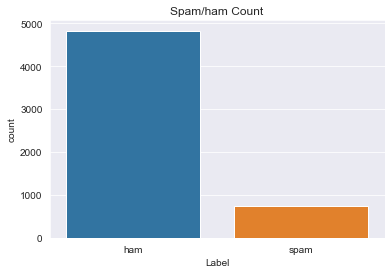

In [3]:
# dataset grouped as per Label
print(sns.countplot(data=sms, x='Label'))
plt.title('Spam/ham Count')

Text(0, 0.5, '')

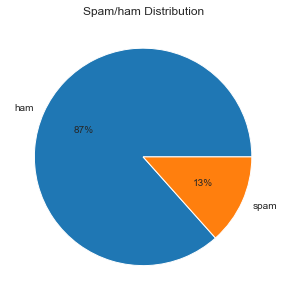

In [4]:
count = pd.value_counts(sms["Label"], sort= True)
count.plot(kind='pie', figsize=(15,5), autopct='%1.0f%%')
plt.title('Spam/ham Distribution')
plt.ylabel('')

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

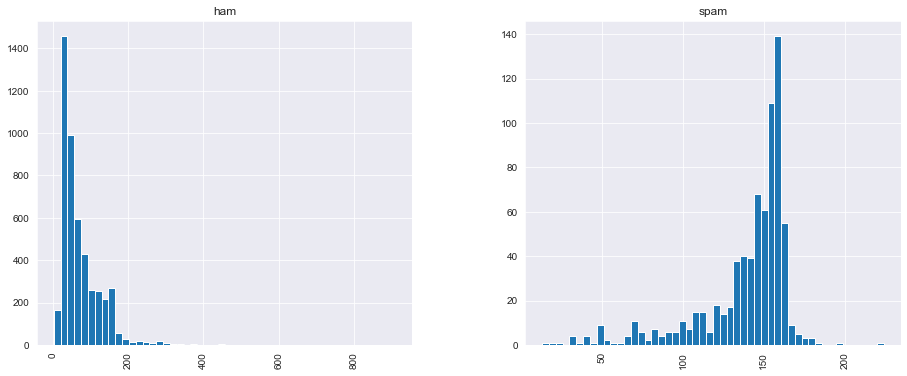

In [5]:
# Length of the messages are calculated and plotted
sms['Length'] = sms.Message.apply(len)
sms.hist(column='Length',by='Label',bins=50, figsize=(15,6))

In [6]:
sms.groupby('Label').describe()

Length                                               
        count   mean   std   min    25%    50%    75%    max
Label                                                       
ham   4825.00  71.02 58.02  2.00  33.00  52.00  92.00 910.00
spam   747.00 138.87 29.18 13.00 132.50 149.00 157.00 224.00

In [7]:
# longest message in the dataset
sms[sms.Length == 910].Message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [8]:
# Example of spam message
sms[sms.Length == 157].Message.iloc[0]

'URGENT! Your Mobile No. was awarded å£2000 Bonus Caller Prize on 5/9/03 This is our final try to contact U! Call from Landline 09064019788 BOX42WR29C, 150PPM'

<div class="alert alert-block alert-warning">
<h1>Observation</h1></div> </h1></div><a class="anchor"></a>

> - There are `4825` ham messages and `747` spam messages
> - `87%` of the messages are ham while `13%` are spam
> - Most of the ham messages have message length of approx `100` while spam messages have around `130-150`.

<div class="alert alert-block alert-info">
<h1>4. Text Processing</h1></div><a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [9]:
def process_text(text):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', '16' ,'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])


sms['clean_msg'] = sms.Message.apply(process_text)
sms.head()

,Label,Message,Length,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes usf lives around though


In [10]:
# Testing the process_text function:
process_text('Hi. My name is Rhea Das, I am a Data Scientist. It\'s amazing!!')

'Hi name Rhea Das Data Scientist amazing'

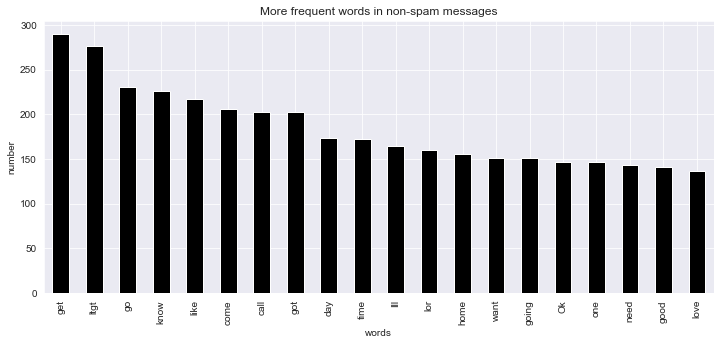

In [11]:
# Visualizing the most common words occuring in Ham

ham_count = Counter(" ".join(sms[sms['Label'] == 'ham']['clean_msg']).split()).most_common(20)
ham_count = pd.DataFrame.from_dict(ham_count)
ham_count = ham_count.rename(columns={0: "words in non-spam", 1 : "count"})

ham_count.plot.bar(legend=False, figsize=(12,5),color = 'black')
y_pos = np.arange(len(ham_count["words in non-spam"]))
plt.xticks(y_pos, ham_count["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [12]:
ham_count

,words in non-spam,count
0,get,290
1,ltgt,276
2,go,231
3,know,226
4,like,217
5,come,206
6,call,203
7,got,202
8,day,173
9,time,172


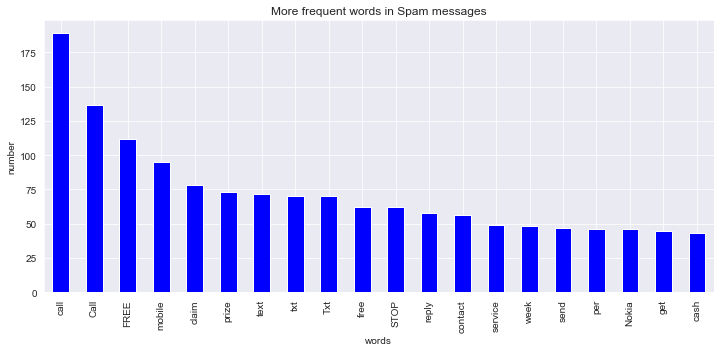

In [13]:
# Visualizing the most common words occuring in Spam

spam_count = Counter(" ".join(sms[sms['Label'] == 'spam']['clean_msg']).split()).most_common(20)
spam_count = pd.DataFrame.from_dict(spam_count)
spam_count = spam_count.rename(columns={0: "words in spam", 1 : "count"})

spam_count.plot.bar(legend=False, figsize=(12,5),color = 'blue')
y_pos1 = np.arange(len(spam_count["words in spam"]))
plt.xticks(y_pos1, spam_count["words in spam"])
plt.title('More frequent words in Spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [14]:
spam_count

,words in spam,count
0,call,189
1,Call,137
2,FREE,112
3,mobile,95
4,claim,78
5,prize,73
6,text,72
7,txt,70
8,Txt,70
9,free,62


<div class="alert alert-block alert-warning">
<h1>Observation</h1></div> </h1></div><a class="anchor"></a>

> - We can see that the majority of frequent words in both classes are stop words such as `'to', 'a', 'or' and so on`. <br>
> - With `stop words` we refer to the most common words in a language. <br>
> - Removing the common words, we have visualized the top 20 most freq words in spam list as well as ham list

<div class="alert alert-block alert-info">
<h1>5. Spliting Dataset to Train and Test</h1></div><a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

In [15]:
# Split into X and Y

X = sms['clean_msg']
Y = sms['Label'].replace({'ham':0,'spam':1})
print("X Dimension", X.shape)
print("Y Dimension", Y.shape)

X Dimension (5572,)
Y Dimension (5572,)


In [16]:
# Splitting X & Y into train and test

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print('X_train Dimension:', x_train.shape)
print('X_test Dimension:', x_test.shape)
print('Y_train Dimension:', y_train.shape)
print('Y_test Dimension:', y_test.shape)

X_train Dimension: (4179,)
X_test Dimension: (1393,)
Y_train Dimension: (4179,)
Y_test Dimension: (1393,)


<div class="alert alert-block alert-comment">
<h1>Word of the wise</h1></div> </h1></div><a class="anchor"></a>

- From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> - Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**. <br>

-  We will use `CountVectorizer` to convert text into a matrix of token counts. In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a `feature`.
> - The vector of all the token frequencies for a given document is considered a `multivariate sample`.

> - A `corpus of documents` can thus be represented by a matrix with **one row per document** and **one column per token** occurring in the corpus.
> - We call `vectorization` the general process of turning a collection of text documents into numerical feature vectors. <br>
> - This specific strategy (tokenization, counting and normalization) is called the `Bag of Words` or `Bag of n-grams` representation. <br>
> - Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

### What we should do with this dataset - Vectorization

> - Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.
> - Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

> **We'll do that in three steps using the bag-of-words model:**
1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

**Summary:**

1. `vect.fit(train)` **learns the vocabulary** of the training data

2. `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data

3. `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

<div class="alert alert-block alert-info">
<h1>6. CountVectorizer</h1></div><a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

In [45]:
 # Initiating Vector
vect = CountVectorizer()

# Fitting the training dataset
vect.fit(x_train)

# learn training data vocabulary, then use it to create a document-term matrix(dtm)
x_train_dtm = vect.transform(x_train) 

# Combine fit and transform 
x_train_dtm = vect.fit_transform(x_train) 

# Transform test dataset into a document-term matrix(dtm)
x_test_dtm = vect.transform(x_test) 

<div class="alert alert-block alert-info">
<h1>7. TF/IDF Vectorization</h1></div><a class="anchor" id="7"></a>

> - `Term Frequency - Inverse Document Frequency` is a numerical statistics that is intended to reflect how important a word is to a document . It is used as a weighing factor in information retrieval and text mining. 
> - TF/IDF value increases proportionally to a no. of times a word appears in a document but is offset by the frequency of the word in corpus.
<br><center>where, `TF-IDF(t)= Term Frequency (TF) * Inverse Document Frequency (IDF)`</center>

> - `Term Frequency (TF)` is a measure of how frequent a term occurs in a document.
<br><center>`TF(t)= Number of times term t appears in document (p) / Total number of terms in that document`</center>
> - `Inverse Document Frequency (IDF)` is measure of how important term is. For TF, all terms are equally treated. But, in IDF, for words that occur frequently like 'is' 'the' 'of' are assigned less weight. While terms that occur rarely that can easily help identify class of input features will be weighted high.
<br><center>`IDF(t)= log<sub><i>e</i></sub>(Total number of documents / Number of documents with term t in it)`</center>

[Back to Table of Contents](#0.1)

In [46]:
 # Initiating Model
tfidf_transformer = TfidfTransformer()

# Fitting the training dataset
tfidf_transformer.fit(x_train_dtm)

# Transforming the test dataset
tfidf_transformer.transform(x_train_dtm)

<4179x7995 sparse matrix of type '<class 'numpy.float64'>'
	with 34761 stored elements in Compressed Sparse Row format>

<div class="alert alert-block alert-info">
<h1>8. Multinomial Naive Bayes Model</h1></div><a class="anchor" id="8"></a>

> - The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
> - The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

[Back to Table of Contents](#0.1)

In [55]:
# Initiating Model
nb = MultinomialNB()

# Train the model using X_train_dtm 
nb.fit(x_train_dtm, y_train)

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(x_test_dtm)

##  Calculating accuracy of the class predictions:
print('Accuracy of Multinomial Naive-Bayes Model:',round(metrics.accuracy_score(y_test, y_pred_class)*100,2))

## Print confusion Metrics
print("\nConfusion Metrics\n", metrics.confusion_matrix(y_test, y_pred_class))

## calculation ROC/AUC
print('\nROC/AUC:',round(metrics.roc_auc_score(y_test, y_pred_class)*100,2))

Accuracy of Multinomial Naive-Bayes Model: 98.35

Confusion Metrics
 [[1206    7]
 [  16  164]]

ROC/AUC: 95.27


In [53]:
# Printing the false positive predictions - The messages which actually HAM but model is predicting SPAM (#7)

x_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [54]:
# Printing the false negetive predictions - The messages which actually SPAM but model is predicting HAM (#16)

x_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

<div class="alert alert-block alert-warning">
<h1>Observation</h1></div> </h1></div><a class="anchor"></a>

> - The goal of the algorithm is to predict if a new sms is a HAM or SPAM and there are 2 possible situation:
> -  `False Positive Prediction`: The messages which actually SPAM but model is predicting HAM 
<br><center> **OUTCOME: I probably do not read it!!** </center>  
> -  `False Negetive Prediction`: The messages which actually HAM but model is predicting SPAM
<br><center> **OUTCOME: I delete it!!** </center>
    
> - The second option is preferable!!

<div class="alert alert-block alert-info">
<h1>9. Pipeline</h1></div><a class="anchor" id="9"></a>

[Back to Table of Contents](#0.1)

In [58]:
# Initiating Model
pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

# Fitting the training dataset
pipe.fit(x_train, y_train)

# Predicting on test dataset
y_pred_pipe = pipe.predict(x_test)

##  Calculating accuracy of the class predictions:
print('Accuracy of Pipeline:',round(metrics.accuracy_score(y_test, y_pred_pipe)*100,2))

## Print confusion Metrics
print("\nConfusion Metrics\n", metrics.confusion_matrix(y_test, y_pred_pipe))

## calculation ROC/AUC
print('\nROC/AUC:',round(metrics.roc_auc_score(y_test, y_pred_pipe)*100,2))

Accuracy of Pipeline: 96.7

Confusion Metrics
 [[1213    0]
 [  46  134]]

ROC/AUC: 87.22


In [70]:
def detect_spam(s):
    return pipe.predict([s])[0]
detect_spam('Hi, this is Rhea.')

0

<div class="alert alert-block alert-warning">
<h1>Observation</h1></div> </h1></div><a class="anchor"></a>

> Pipeline is predicting the spam messages with 96% accuracy with lowset False Positives.

___